<a href="https://colab.research.google.com/github/nikitaoltyan/ML-Homework/blob/main/Neural_Network_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [62]:
# Запустите эту ячейку если работаете в Colab
!git clone https://github.com/nikitaoltyan/ML-Homework.git
%cd ML-Homework/data
! wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
%cd ../Assignment3

[autoreload of layers failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name 'self' is not defined
]


Cloning into 'ML-Homework'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 125 (delta 40), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (125/125), 144.21 KiB | 4.97 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/content/ML-Homework/Assignment3/ML-Homework/data
--2021-03-12 12:08:19--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  55.3MB/s    in 3.1s    

2021-03-12 12:08:23 (55.3 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-03-12 12:08:23--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connectio

In [63]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [65]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("../data", max_train=10000, max_test=1000)    

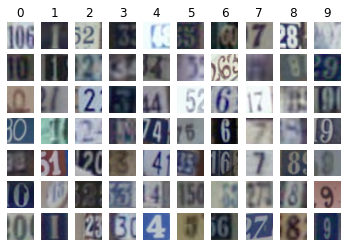

In [66]:
# Перед началом работы полезно посмотреть на данные.
# Отобразим пример из каждого класса.
classes = [str(i) for i in range(10)]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_y == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [67]:
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [68]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

1.6159940625632276 1.6159940625648515
0.0 0.0
2.7625252407895857 2.7625252407403873
-0.0 0.0
-0.5060347044691067 -0.506034704450542
-0.9430251923423104 -0.9430251923348009
Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [69]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

-0.00024817096524020675 -0.0002481709652395799
0.0002146482702264245 0.00021464827023014857
-6.530860670916744e-05 -6.530860670512541e-05
5.307254416897368e-05 5.3072544162159265e-05
0.0002792766125516806 0.0002792766125509546
-8.016715300085219e-05 -8.016715299951661e-05
Gradient check passed!
-1.503322498821751 -1.5033224988218392
1.8302383552330634 1.830238355233181
0.9357797158664962 0.9357797158665234
-0.3065670448789982 -0.30656704487902475
3.006644997643502 3.0066449976435052
-3.660476710466127 -3.660476710466188
-1.8715594317329924 -1.8715594317330468
0.6131340897579964 0.6131340897579627
0.1503322498821751 0.15033224988218394
5.49071506569919 5.490715065699196
-0.09357797158664963 -0.09357797158661764
-0.9197011346369947 -0.9197011346369874
Gradient check passed!
0.0 0.0
-1.8680222870794265 -1.8680222870794385
1.7534099466422033 1.7534099466422115
-0.5310369506176832 -0.5310369506176648
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [71]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Выходные данные были обрезаны до нескольких последних строк (5000).
0.0 0.0
0.0002553650088847654 0.00025536501802037037
7.109019129636038e-05 7.109020039308689e-05
0.0 0.0
0.0002947068871779654 0.0002947068811209874
5.964020360060014e-05 5.964018168214124e-05
0.0 0.0
0.00035423738793368575 0.00035423739497275614
-2.2525516362505036e-05 -2.252551478676423e-05
0.0 0.0
0.00023990697626973567 0.00023990698316822542
7.236753377099318e-05 7.236753418737862e-05
0.0 0.0
0.00027116043782357096 0.0002711604496496989
6.451434860144911e-05 6.451434941823209e-05
0.0 0.0
0.0003468302183802457 0.0003468302312015225
-1.0528096177614976e-05 -1.052808951129691e-05
0.0 0.0
0.00014859403520211354 0.00014859404817713084
7.295488321245374e-05 7.295488657632632e-05
0.0 0.0
0.00017166460904592467 0.00017166459365114403
6.885151555306783e-05 6.885152448177223e-05
0.0 0.0
0.00025746302724245475 0.000257463028674465
-8.340267028361599e-06 -8.340284018970578e-06
0.0 0.0
-2.1559038313279515e-05 -2.155904343936754

True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [72]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Выходные данные были обрезаны до нескольких последних строк (5000).
-0.006911591882431852 -0.0069115918766016185
0.02199856334727947 0.021998563348724073
-0.020354483470679315 -0.020354483498685738
-0.00274907466089465 -0.002749074679009311
0.016974396954584768 0.01697439693248981
-0.02130676617473602 -0.021306766151418795
-0.009131118485004563 -0.00913111850575632
-0.025601167967563985 -0.025601167985556113
-0.017367846441242882 -0.017367846472104986
-0.03102123563579533 -0.031021235646910835
-0.021238764888803247 -0.02123876485793374
-0.026190342430595235 -0.02619034245032736
-0.0132853126789783 -0.013285312694399918
0.019410988303597065 0.019410988261192585
0.005601310279195324 0.005601310282266069
0.026035064346384744 0.026035064348839395
-0.007793066782208242 -0.0077930667918835175
-0.017941263796566614 -0.017941263785736794
-0.0025054087635688425 -0.002505408747133231
-0.012164291703793625 -0.0121642917294551
0.008215698300765182 0.008215698321656362
-0.030044648019875213 -0.0300

True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [75]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30])

0.16666666666666666

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться в некоторых эпохах. Не беспокойтесь пока про validation accuracy.

In [77]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Exception: ignored

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [ ]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [ ]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [ ]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [ ]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [ ]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))